
# HPC Application: FastEddy

**Purpose:** A concise, hands-on overview of the FastEddy LES model as an HPC workload: what it does, the math it solves, the GPU/MPI tech stack, how to run it (e.g., in Docker), and some visualizations. 


## 1) What is FastEddy? Purpose & Use Cases <a id="what-is-fasteddy"></a>

* [**FastEddy**](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020MS002100) is a GPU‑ based **Large Eddy Simulation (LES)** model aimed at microscale atmospheric flows(street/urban scale to ABL)
* It resolves the large turbulent eddies while modeling subgrid‑scale (SGS) effects, enabling real‑time to faster‑than‑real‑time studies of urban weather, dispersion, and wind‑energy scenarios.
* Specifically, an eddy is the swirling of a fluid and the reverse current created when the fluid is in a turbulent flow regime

**Typical use cases**
- Urban/street‑scale micro‑meteorology
- Plume/dispersion studies



## 2) Mathematical Formulation (LES, compressible core) <a id="math"></a>

* FastEddy use the compressible, Favre‑filtered Navier–Stokes equations in conservative form
* Solving the Navier Stokes equations is difficult because their solution involves resolving dynamics aat a wide range of time and lenght scales
* A large eddy simulation attempts to reduce this computational cost by ignoring the smallest lenght scales, which are the most expensive to resolve, via low pass filtering of the governing equations
* The low pass filtering effectively removes the small-scale information from the numerical solution

### The LES Filter
A large eddy simulation uses a filter like this
$$ \overline{\phi(x,t)} = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \phi(\pmb{r}, \tau) G(\pmb{x}-\pmb{r}, t-\tau) d \tau d \pmb{r} $$
where $G$ is the filter convolution kernel. For the compressible Navier-Stokes equations, a density weighted filter called a Favre filter is used specifically
$$ \tilde{\phi} = \frac{\overline{\rho \phi}}{\overline{\rho}}$$
We apply the filter to the left and right hand side of all governing equations, leading to a transformed system of equations. 

**Mass Continuity**
$$
\boxed{\;
\frac{\partial \bar{\rho}}{\partial t}
+ \nabla \!\cdot (\bar{\rho}\,\tilde{\boldsymbol{u}}) = 0
\;}
$$


**Momentum**

The subgrid-scale (SGS) stress tensor is given by:
$$
\tau^{\mathrm{sgs}}_{ij}
= \overline{\rho\,u_i u_j}
- \bar{\rho}\,\tilde{u}_i \tilde{u}_j .
$$
The filtered momentum equation becomes
$$
\boxed{\;
\frac{\partial (\bar{\rho}\,\tilde{u}_i)}{\partial t}
+ \frac{\partial}{\partial x_j}
\big(\bar{\rho}\,\tilde{u}_i \tilde{u}_j\big)
= -\,\frac{\partial \bar{p}}{\partial x_i}
+ \frac{\partial \overline{\tau^{\nu}_{ij}}}{\partial x_j}
- \frac{\partial \tau^{\mathrm{sgs}}_{ij}}{\partial x_j}
\;}
$$
where the viscous stress tensor is
$$
\tau^{\nu}_{ij}
= 2\mu S_{ij}
- \tfrac{2}{3}\mu\,(\nabla\!\cdot\!\boldsymbol{u})\,\delta_{ij},
\qquad
S_{ij} = \tfrac{1}{2}
\left(
\frac{\partial u_i}{\partial x_j}
+ \frac{\partial u_j}{\partial x_i}
\right).
$$


**Total Energy**

Let $E = e + \tfrac{1}{2}u_k u_k$ be the specific total energy, and define the SGS energy and pressure–velocity fluxes:
$$
q^{\mathrm{sgs}}_j = \overline{\rho E u_j} - \bar{\rho}\,\tilde{E}\,\tilde{u}_j,
\qquad
J^{\mathrm{sgs}}_j = \overline{p u_j} - \bar{p}\,\tilde{u}_j.
$$
Then
$$
\boxed{\;
\frac{\partial (\bar{\rho}\,\tilde{E})}{\partial t}
+ \frac{\partial}{\partial x_j}
\Big[
(\bar{\rho}\,\tilde{E}+\bar{p})\,\tilde{u}_j
- \overline{\tau^{\nu}_{ij}}\,\tilde{u}_i
- \overline{q^{\nu}_j}
\Big]
= -\,
\frac{\partial}{\partial x_j}
\Big(
q^{\mathrm{sgs}}_j
+ J^{\mathrm{sgs}}_j
- \tau^{\mathrm{sgs}}_{ij}\,\tilde{u}_i
\Big)
\;}
$$

### Closure Models
Note that the subgrid scale stress tensor depends not only on the transformed velocities, but also on the original velocities. Hence, we have more unkowns than equations. To remedy this issue, we assume that this tensor can be written purely in terms of the filtered variables. For example, one assumption is as follows:

**SGS stress (Boussinesq/eddy-viscosity form):**
  $$
  \tau^{\mathrm{sgs}}_{ij}
  - \tfrac{1}{3}\tau^{\mathrm{sgs}}_{kk}\,\delta_{ij}
  = -2\,\bar{\rho}\,\nu_t\,\tilde{S}_{ij},
  \qquad
  \nu_t = (C_s\,\Delta)^2\,|\tilde{S}|,
  $$
  with $C_s$ the Smagorinsky constant and $\Delta$ the filter width.



## 3) Numerics & Algorithm 

**Discretization:**
- Structured rectilinear grid (finite‑difference style stencils)
- High‑order advection options (e.g., QUICK, WENO3/5, centered)
- Explicit split‑explicit RK3 time stepping (Wicker–Skamarock‑style)
- Optional immersed body‑force method for buildings



## 4) HPC Tech Stack (CUDA, MPI, multi‑GPU) <a id="tech"></a>
FastEddy takes advantage of some of the tools we've discussed in class. Notably, one of the coolest features of MPI is that it supports multi-GPU distributede computing as well as multiprocessor / node computing. This lets FastEddy take advantage of multiple GPUs simultaneously. 

- **CUDA**: GPU device kernels for fluxes, SGS, and update steps; data stays on device.
- **MPI**: Domain decomposition in the horizontal (2‑D rank grid); **1 rank per GPU** is the common mapping.
- **Multi‑GPU**: Ghost/halo exchanges via MPI; each rank controls one GPU.
- **I/O**: Binary (fast) and optional NetCDF outputs.
- **Containers**: Runs well inside Docker with NVIDIA Container Toolkit; easy to showcase on desktops or cloud VMs.



## 5) How to Run (Docker + single‑GPU SBL demo) <a id="run"></a>

I was able to get a version of FastEddy running on my desktop, which has a single RTX 4090 GPU. I used the following Dockerfile, which will intall all necessary dependencies, clone the FastEddy model and build it. 

```bash
# Dockerfile.fasteddy
FROM nvidia/cuda:12.3.2-devel-ubuntu22.04

RUN apt-get update && DEBIAN_FRONTEND=noninteractive \
 && apt-get install -y --no-install-recommends \
      build-essential git openmpi-bin libopenmpi-dev \
      libnetcdf-dev netcdf-bin ca-certificates \
 && rm -rf /var/lib/apt/lists/*
 
# after installing deps, before RUN make
ENV CPATH=/usr/lib/x86_64-linux-gnu/openmpi/include:/usr/local/cuda/include \
    LIBRARY_PATH=/usr/local/cuda/lib64 \
    LD_LIBRARY_PATH=/usr/local/cuda/lib64 \
    CUDA_HOME=/usr/local/cuda

# Fetch FastEddy v4 sources
WORKDIR /opt
RUN git clone --branch main_v4.0 https://github.com/NCAR/FastEddy-model.git
WORKDIR /opt/FastEddy-model/SRC/FEMAIN

# Build
RUN make

# Default workdir with examples
WORKDIR /workspace
ENV SRCDIR=/opt/FastEddy-model/SRC/FEMAIN \
    TUTORIALDIR=/opt/FastEddy-model/tutorials

# Example command (can be overridden with `docker run ... <your .in>`)
CMD ["bash", "-lc", "mkdir -p output && cd output && mpirun -np 1 $SRCDIR/FastEddy $TUTORIALDIR/examples/Example01_NBL.in"]
```

If you are currently in the directory containing this Dockerfile, you can build it with 
```bash
docker build -t fasteddy:cuda -f Dockerfile.fasteddy .
```

As a test simulation, I'm going to modify one of the existing tutorial simulations, creating a new input file for FastEddy called example.in. This has a lot of stuff going on, but I'll point out a couple of things in particular in class. 

```bash
Description = This is an idealized Stable Boundary Layer V&V scenario (GABLS1).
#--MPI_AALES
numProcsX = 1 # Number of cores to be used for horizontal domain decomposition in X
numProcsY = 1 # Number of cores to be used for horizontal domain decomposition in Y
#--CUDA_AALES
tBx = 1 # Number of threads in x-dimension
tBy = 4 # Number of threads in y-dimension
tBz = 64 # Number of threads in z-dimension
#--IO
inPath = # Path where initial/restart file is read in from
inFile = # name of the input file for coordinate system and initial or restart conditions
outPath = ./output/ # Path where output files are to be written
outFileBase = FE_SBL # Base name of the output file series as in (outFileBase).element-in-series
frqOutput = 360 # frequency (in timesteps) at which to produce output
ioOutputMode = 0 # 0: N-to-1 gather and write to a netcdf file, 1:N-to-N writes of FastEddy binary files
#--GRID
Nx = 128 # Number of discretised domain elements in the x (zonal) direction
Ny = 126 # Number of discretised domain elements in the y (meridional) direction
Nz = 122 # Number of discretised domain elements in the z (vertical) direction
Nh = 3 # Number of halo cells to be used (dependent on largest stencil extent)
d_xi = 3.125 # Computational domain fixed resolution in the 'i' direction
d_eta = 3.125 # Computational domain fixed resolution in the 'j' direction
d_zeta = 3.125 # Computational domain fixed resolution in the 'k' direction
coordHorizHalos = 1 # switch to setup coordiante halos as periodic=1 or gradient-following=0
topoFile = # A file containing topography (surface elevation in meters ASL)
verticalDeformSwitch = 0 # switch to use vertical coordinate deformation 0=off, 1=on
verticalDeformFactor = 0.8 # deformation factor (0.0=max compression,  1.0=no compression)
verticalDeformQuadCoeff = 0.0 # deformation factor (0.0=max compression,  1.0=no compression)
#--TIME_INTEGRATION
timeMethod = 0 # Selector for time integration method. [0=RK3-WS2002 (default)]
Nt = 864000 # Number of timesteps to perform
dt = 0.005 # timestep resolution in seconds
NtBatch = 36000 # Number of timesteps to compute in batch launch, must have NtBatch <= Nt
#--HYDRO_CORE
##------------: HYDRO_CORE Submodule Selectors ---
#----------: Boundary Conditions Set ---
hydroBCs =  2 # Selector for hydro BC set. 2= periodicHorizVerticalAbl
##----------: HYDRO_IO/LOGGGING ---
hydroForcingWrite = 0 # Switch for dumping hydroFldsFrhs for prognositic fields. 0 = off, 1=on
hydroSubGridWrite = 1 # Switch for dumping Tauij fields. 0 = off, 1=on
hydroForcingLog = 0 # switch for logging Frhs min/max, etc.
##----------: ADVECTION ---
advectionSelector = 3 # advection scheme selector: 0= 1st-order upwind, 1= 3rd-order QUICK, 2= hybrid 3rd-4th order, 3= hybrid 5th-6th order
b_hyb = 0.0 # hybrid advection scheme parameter: 0.0= lower-order upwind, 1.0=higher-order cetered, 0.0 < b_hyb < 1.0 = hybrid
##------------: MOISTURE ---
moistureSelector = 0 # moisture selector: 0=off, 1=on
moistureNvars = 2 # number of moisture species
moistureAdvSelectorQv = 2 # water vapor advection scheme selector
moistureAdvSelectorQv_b = 0.0 # hybrid advection scheme parameter for water vapor
moistureAdvSelectorQi = 2 # moisture advection scheme selector for non-qv fields (non-oscillatory schemes)
moistureSGSturb = 1 # selector to apply sub-grid scale diffusion to moisture fields
moistureCond = 3 # selector to apply condensation to mositure fields
moistureCondTscale = 1.0 # relaxation time in seconds
moistureCondBasePres = 1 #selector to use base pressure for microphysics
moistureMPcallTscale = 1.0 # time scale for microphysics to be called
##------------: CORIOLIS ---
coriolisSelector = 1  #Coriolis switch: 0 off, 1 on
coriolisLatitude = 73.0 # Charactersitc latitude in degrees from equator of the LES domain
## ----------: TURBULENCE ---
turbulenceSelector = 1 # turbulence scheme selector: 0= none, 1= Lilly/Smagorinsky
TKESelector = 1 # Prognostic TKE selector: 0= none, 1= Prognostic
TKEAdvSelector = 3 # SGSTKE advection selector
TKEAdvSelector_b_hyb = 0.0
c_s = 0.18 # Smagorinsky turbulence model constant used for turbulenceSelector = 1 with TKESelector = 0
c_k = 0.10 # Lilly turbulence model constant used for turbulenceSelector = 1 with TKESelector > 0
##------------: DIFFUSION ---
diffusionSelector = 0 # diffusivity selector: 0= none, 1= const.
nu_0 = 0.0 # constant diffusivity used when diffusionSelector = 1
##------------: EXPLICIT FILTERS ---
filterSelector = 0 # explicit filter selector: 0=off, 1=on
filter_6thdiff_vert = 1 # vertical 6th-order filter on w selector: 0=off, 1=on
filter_6thdiff_vert_coeff = 0.03 # vertical 6th-order filter factor: 0.0=off, 1.0=full
##----------: RAYLEIGH DAMPING LAYER ---
dampingLayerSelector = 1 # Rayleigh damping layer selector: 0= off, 1= on.
dampingLayerDepth = 100.0 # Rayleigh damping layer depth in meters
##----------: SURFACE LAYER ---
surflayerSelector = 2 # surfacelayer selector: 0= off, 1= surface kinematic heat flux (surflayer_wth), 2=sking temperature rate (surflayer_tr)
surflayer_z0 = 0.1 # roughness length (momentum) when surflayerSelector > 0
surflayer_z0t = 0.1 # roughness length (temperature) when surflayerSelector > 0
surflayer_wth = 0.0 # kinematic sensible heat flux at the surface when surflayerSelector = 1
surflayer_tr = -0.25 # temperature rate at the surface when surflayerSelector = 2 (>0 for warming; <0 for cooling)
surflayer_wq = 0.0 # latent heat flux at the surface (kg/kg m s-1) when surflayerSelector = 1
surflayer_qr = 0.0 # water vapor rate (kg/kg h-1) when surflayerSelector = 2
surflayer_idealsine = 0 # selector for idealized sinusoidal surface heat flux or skin temperature forcing
surflayer_ideal_ts = 0.0 # start time in seconds for the idealized sinusoidal surface forcing
surflayer_ideal_te = 43200 # end time in seconds for the idealized sinusoidal surface forcing
surflayer_ideal_amp = 4.0 # maximum amplitude of the idealized sinusoidal surface forcing
surflayer_ideal_qts = 1.75 # start time in seconds for the idealized sinusoidal surface forcing (qv)
surflayer_ideal_qte = 10.0 # end time in seconds for the idealized sinusoidal surface forcing (qv)
surflayer_ideal_qamp = 2.0 # maximum amplitude of the idealized sinusoidal surface forcing (qv)
surflayer_offshore = 0 # offshore selector: 0=off, 1=on
#------------: BASE-STATE ---
stabilityScheme = 2 # Scheme used to set hydrostatic, stability-dependent Base-State EOS fields
temp_grnd = 265.0 # Air Temperature (K) at the ground used to set hydrostatic Base-State EOS fields
pres_grnd = 100000.0 # Pressure (Pa) at the ground used to set hydrostatic Base-State EOS fields
zStableBottom = 100.0 # Height (m) of the first stable upper-layer when stabilityScheme = 1 or 2
stableGradient = 0.01 # Vertical gradient (K/m) of the first stable upper-layer when stabilityScheme = 1 or 2
zStableBottom2 = 6000.0 # Height (m) of the second stable upper-layer when stabilityScheme = 2
stableGradient2 = 0.08 # Vertical gradient (K/m) of the second stable upper-layer when stabilityScheme = 2
zStableBottom3 = 50000.0 # Height (m) of the third stable upper-layer when stabilityScheme = 2
stableGradient3 = 0.003 # Vertical gradient (K/m) of the third stable upper-layer when stabilityScheme = 2
thetaPerturbationSwitch = 1 # Switch to include initial theta perturbations: 0=off, 1=on
thetaHeight = 75.0 # Height below which to include initial theta perturbations: (meters)
thetaAmplitude = 0.25 # Maximum amplitude for theta perturbations: thetaAmplitude*[-1,+1] K
U_g = 8.0 # Zonal (West-East) component of the geostrophic wind (m/s)
V_g = 0.0 # Meridional (South-North) component of the geostrophic wind (m/s)
z_Ug = 10000.0 # Height (m) above ground for linear geostrophic wind gradient (zonal component)
z_Vg = 10000.0 # Height (m) above ground for linear geostrophic wind gradient (meridional component)
Ug_grad = 0.0 # U_g gradient above z_Ug (ms-1/m)
Vg_grad = 0.0 # V_g gradient above z_Vg (ms-1/m)
# ----------: LARGE SCALE FORCINGS ---
lsfSelector = 0 # large-scale forcings selector: 0=off, 1=on
lsf_horMnSubTerms = 0 # large-scale subsidence terms Switch: 0= off, 1= on
lsf_freq = 1.0 # large-scale forcing frequency (seconds)
lsf_w_surf = 0.0 # lsf to w at the surface
lsf_w_lev1 = -23.4 # lsf to w at the first specified level
lsf_w_lev2 = 0.0 # lsf to w at the second specified level
lsf_w_zlev1 = 1500.0 # lsf to w height 1
lsf_w_zlev2 = 2100.0 # lsf to w height 2
lsf_th_surf = -0.0833333 # lsf to theta at the surface
lsf_th_lev1 = -0.0833333 # lsf to theta at the first specified level
lsf_th_lev2 = 0.0 # lsf to theta at the second specified level
lsf_th_zlev1 = 1500.0 # lsf to theta height 1
lsf_th_zlev2 = 3000.0 # lsf to theta height 2
lsf_qv_surf = -0.0432 # large-scale forcing to qv at the first specified level
lsf_qv_lev1 = -0.0432 # large-scale forcing qv at height 1
lsf_qv_lev2 = 0.0 # large-scale forcing qv at height 2
lsf_qv_zlev1 = 300.0 # large-scale forcing qv height 1
lsf_qv_zlev2 = 500.0 # large-scale forcing qv height 2
```

To run the example script we'll create a new folder to store the output. 
```bash 
mkdir -p fe_out
```
Then we'll do a docker run command that takes in the example.in file defined in the current working directory. 

```bash

docker run --rm -it --gpus all \
  -e OMPI_ALLOW_RUN_AS_ROOT=1 -e OMPI_ALLOW_RUN_AS_ROOT_CONFIRM=1 \
  -v "$PWD/fe_out":/workspace/output \
  -v "$PWD/example.in":/workspace/case.in:ro \
  fasteddy:cuda \
  bash -lc '/usr/bin/mpirun --allow-run-as-root -np 1 "$SRCDIR/FastEddy" /workspace/case.in && ls -lh /workspace/output'
```


## 6) Load & Plot the Output <a id="plot"></a>

This current `example.in` file outputs in netcdf format. So let's plot a slice of the wind field.  

/tmp/ipykernel_3750/4103259714.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  mid = ds.dims[zdim] // 3


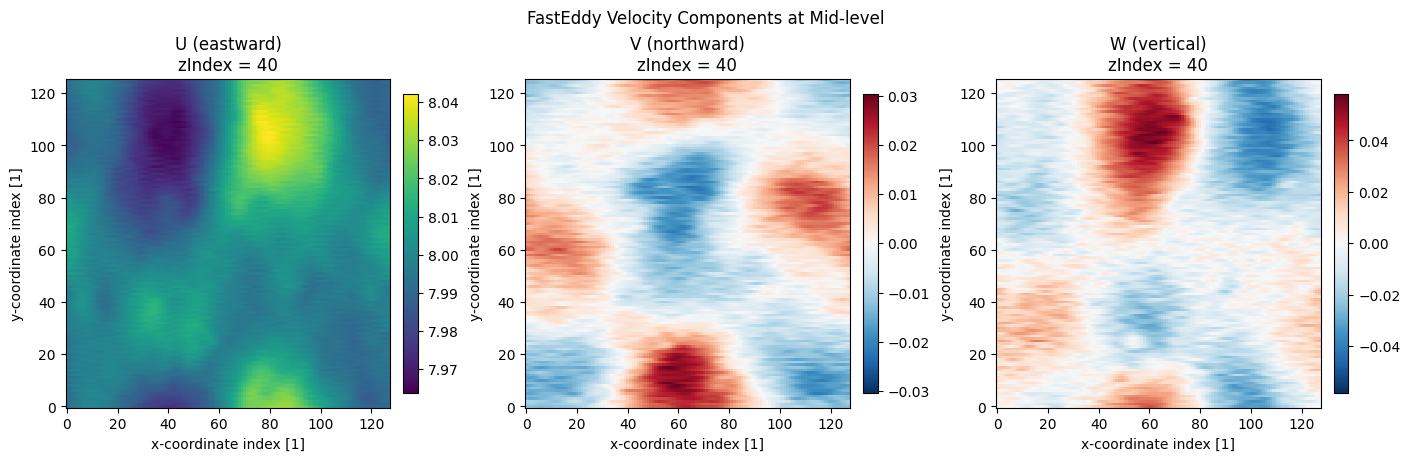

In [12]:
import xarray as xr
import matplotlib.pyplot as plt 
ds = xr.open_dataset("fe_out/FE_SBL.108000", engine="netcdf4")  # adjust to your file

# Get a mid-level index in the vertical dimension 
zdim = "zIndex" if "zIndex" in ds.dims else list(ds.dims.keys())[1]
mid = ds.dims[zdim] // 3

# Extract the 3 velocity components 
u = ds["u"].isel({zdim: mid, "time": 0})
v = ds["v"].isel({zdim: mid, "time": 0})
w = ds["w"].isel({zdim: mid, "time": 0})

# Plot them 
fig, axes = plt.subplots(1, 3, figsize=(14, 4.5), constrained_layout=True)
for ax, var, title in zip(axes, [u, v, w], ["U (eastward)", "V (northward)", "W (vertical)"]):
    im = var.plot(ax=ax, add_colorbar=False)
    ax.set_title(f"{title}\n{zdim} = {mid}")
    plt.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
plt.suptitle("FastEddy Velocity Components at Mid-level")
plt.show()

There are some really cool videos in the FastEddy user guide!

In [19]:
from IPython.display import HTML
HTML("""
<a href="https://www.youtube.com/watch?v=vdFheNud8AY&t=72s" target="_blank" rel="noopener">
  <img src="https://img.youtube.com/vi/vdFheNud8AY/hqdefault.jpg"
       alt="Open video on YouTube" style="width:640px;height:auto;border:0;">
</a>
""")


## References <a id="refs"></a>

- FastEddy documentation & tutorials (SBL/CBL/urban cases) on ReadTheDocs.
- Core formulation & urban extensions in the published papers (Sauer 2020 & follow‑ups).